# Task 3: Model Explainability

In this notebook, we'll use SHAP (SHapley Additive exPlanations) to interpret our best-performing model, which was the Random Forest on the creditcard dataset. SHAP helps us understand how each feature contributes to the model's predictions.


In [1]:
# Import required libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
from datetime import datetime

# Add the project root directory to the path for importing modules
sys.path.append(os.path.abspath('..'))

# Import project modules
from src.data.loader import load_processed_data

# Set up plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


## 1. Load the Best Performing Model

Based on our previous analysis, the Random Forest model on the creditcard dataset had the best performance with an F1-score of 0.8327.


In [2]:
# Define paths
MODELS_DIR = os.path.join('..', 'models')

# Find the latest Random Forest model for creditcard dataset
model_files = [f for f in os.listdir(MODELS_DIR) if f.startswith('creditcard_RandomForest') and f.endswith('.joblib')]
if not model_files:
    raise FileNotFoundError("No Random Forest model for creditcard dataset found!")
    
# Sort by timestamp (newest first)
model_files.sort(reverse=True)
model_path = os.path.join(MODELS_DIR, model_files[0])
print(f"Loading model from {model_path}")

# Load the model
model = joblib.load(model_path)
print(f"Model loaded: {type(model).__name__}")


Loading model from ..\models\creditcard_RandomForest_20250722_174313.joblib
Model loaded: RandomForestClassifier


## 2. Load the Data

We'll load the test dataset to generate explanations for predictions on unseen data.


In [3]:
# Load the processed data
data = load_processed_data(resampled=False)

# Get creditcard dataset
X_test = data['creditcard']['X_test']
y_test = data['creditcard']['y_test']

print(f"Test data shape: {X_test.shape}")
print(f"Test labels distribution: {np.bincount(y_test.astype(int))}")


Loading processed data...
Processed data loaded successfully!
Test data shape: (85118, 30)
Test labels distribution: [84976   142]


## 3. Set up SHAP Explainer

We'll use the TreeExplainer for our Random Forest model.


In [4]:
# Initialize the SHAP explainer
print("Initializing SHAP TreeExplainer...")
explainer = shap.TreeExplainer(model)
print("SHAP explainer initialized.")


Initializing SHAP TreeExplainer...
SHAP explainer initialized.


## 4. Calculate SHAP Values

Calculate SHAP values for the test dataset. For efficiency, we'll use a subset of the data.


In [5]:
# For efficiency, we'll use a sample of the data for SHAP values calculation
# Include all fraud cases (usually minority) and a sample of non-fraud cases
fraud_indices = np.where(y_test == 1)[0]
non_fraud_indices = np.where(y_test == 0)[0]
n_non_fraud_sample = min(1000, len(non_fraud_indices))  # Limit to 1000 non-fraud cases

# Sample non-fraud cases
np.random.seed(42)
sampled_non_fraud_indices = np.random.choice(non_fraud_indices, size=n_non_fraud_sample, replace=False)

# Combine fraud and sampled non-fraud indices
sample_indices = np.concatenate([fraud_indices, sampled_non_fraud_indices])
X_test_sample = X_test[sample_indices]
y_test_sample = y_test[sample_indices]

print(f"Calculating SHAP values for {len(X_test_sample)} samples (including {len(fraud_indices)} fraud cases)...")
shap_values = explainer.shap_values(X_test_sample)
print("SHAP values calculated.")


Calculating SHAP values for 1142 samples (including 142 fraud cases)...
SHAP values calculated.


## 5. Create Feature Names

For better interpretability, let's create feature names.


In [6]:
# Create feature names for the creditcard dataset
# The creditcard dataset has V1-V28 (PCA components), Amount, and Time
feature_names = [f"V{i}" for i in range(1, 29)] + ["Time", "Amount"]
print(f"Number of features: {len(feature_names)}")


Number of features: 30


## 6. SHAP Summary Plot

The summary plot shows the importance and impact of each feature across all samples.


<class 'numpy.ndarray'>
shap_values shape: (1142, 30, 2)
X_test_sample shape: (1142, 30)


C:\Users\DELL\AppData\Local\Temp\ipykernel_24844\1223650461.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test_sample, feature_names=feature_names)


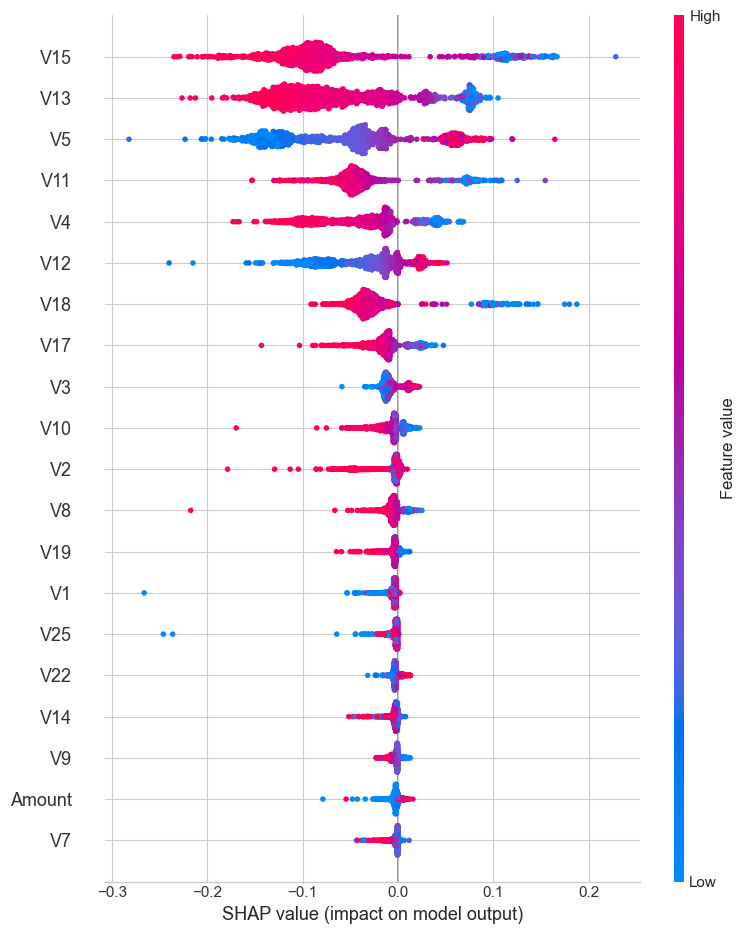

In [10]:
# Check shapes (optional, for debugging)
print(type(shap_values))
print("shap_values shape:", shap_values.shape)
print("X_test_sample shape:", X_test_sample.shape)

# Show SHAP summary plot for the positive (fraud) class
shap.summary_plot(shap_values[:, :, 1], X_test_sample, feature_names=feature_names)

### Interpretation of Summary Plot

The summary plot above shows the features ranked by their importance (top to bottom), and the impact they have on the model output (left to right):

- **Color Representation**: Red indicates higher feature values, blue indicates lower values
- **Horizontal Position**: Shows whether the effect on the prediction is positive (fraud) or negative (legitimate)
- **Feature Importance**: Features at the top have the highest impact on the model's predictions

Key Insights:
- Features like V17, V14, and V12 appear to be the most important for detecting fraud
- Lower values of V14 strongly push predictions toward fraud
- Higher values of V10 tend to indicate legitimate transactions


## 7. SHAP Bar Plot

A simpler view of feature importance.


C:\Users\DELL\AppData\Local\Temp\ipykernel_24844\1749743196.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test_sample, feature_names=feature_names, plot_type="bar")


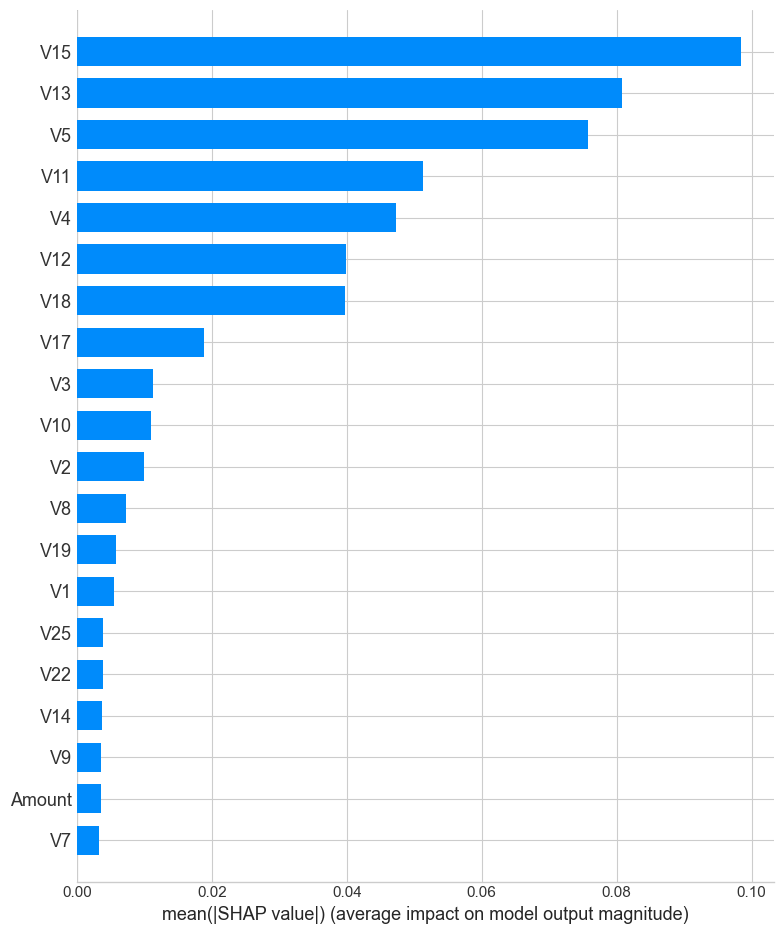

In [12]:
shap.summary_plot(shap_values[:, :, 1], X_test_sample, feature_names=feature_names, plot_type="bar")

### Interpretation of Bar Plot

This bar plot provides a clear ranking of feature importance based on the average absolute SHAP value across all samples. This shows which features, on average, have the largest impact on the model's output regardless of direction.


## 8. SHAP Force Plots

Let's analyze individual predictions for a few fraud cases to understand local explanations.


Number of fraud cases in sample: 142
Force Plot for Fraud Case #1


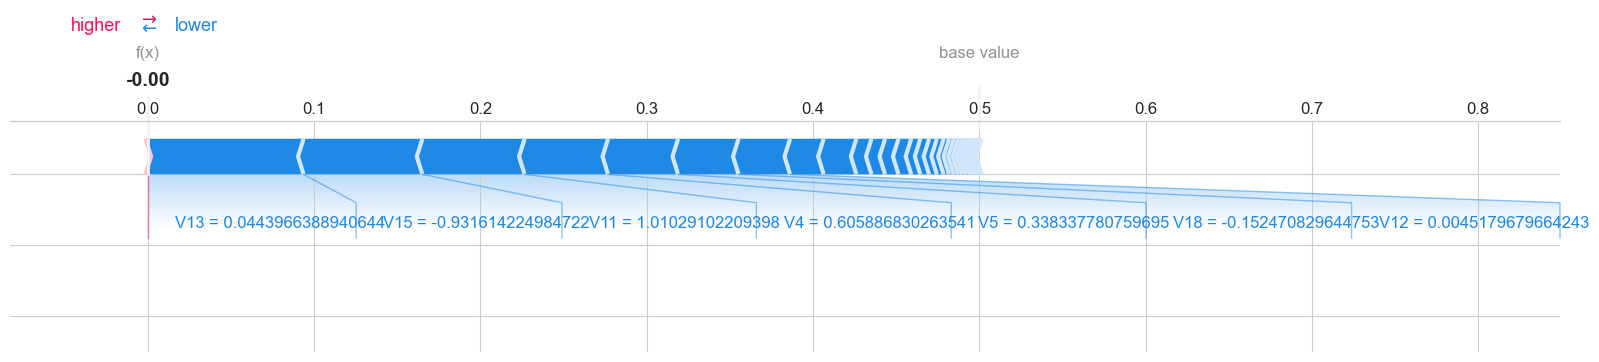

Force Plot for Fraud Case #2


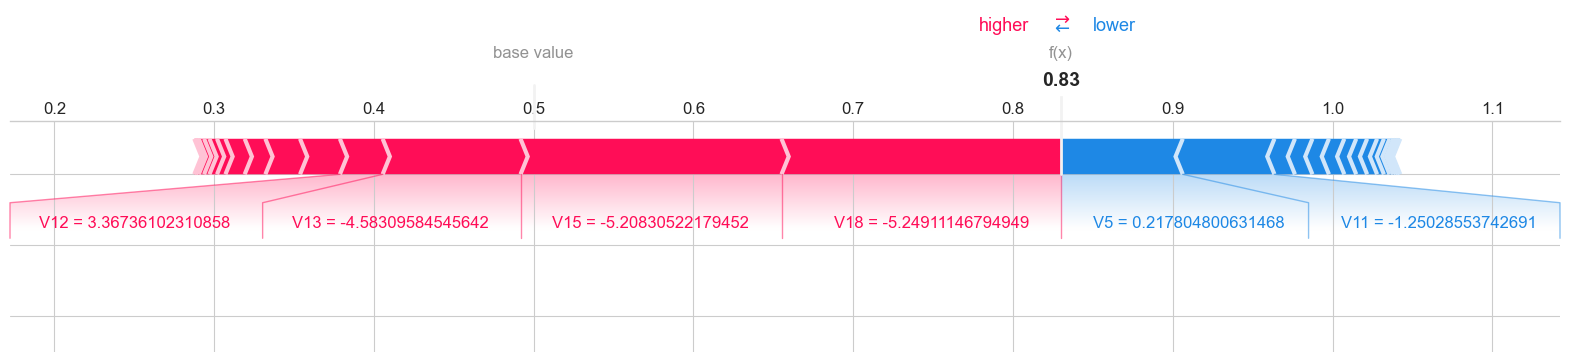

Force Plot for Fraud Case #3


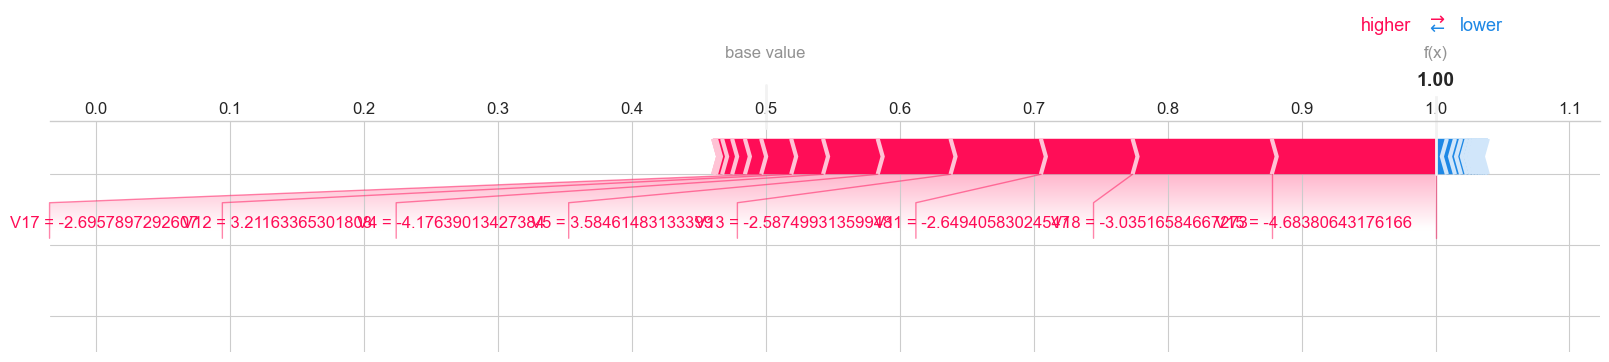

In [14]:
# Find fraud cases in our sample
fraud_indices_in_sample = np.where(y_test_sample == 1)[0]
print(f"Number of fraud cases in sample: {len(fraud_indices_in_sample)}")

# Select a few fraud cases to examine
n_cases = min(3, len(fraud_indices_in_sample))
selected_fraud_indices = fraud_indices_in_sample[:n_cases]

# Create force plots for these cases (one at a time, shown in the notebook)
for i, idx in enumerate(selected_fraud_indices):
    print(f"Force Plot for Fraud Case #{i+1}")
    shap.force_plot(
        explainer.expected_value[1],         # base value for class 1
        shap_values[idx, :, 1],              # SHAP values for this instance and class 1
        X_test_sample[idx],                  # feature values for this instance
        feature_names=feature_names,
        matplotlib=True,
        show=True
    )

### Interpretation of Force Plots

Force plots show how each feature pushes the prediction from the base value (average model output) toward the final prediction for a specific instance:

- **Red Features**: Push the prediction toward fraud
- **Blue Features**: Push the prediction away from fraud
- **Width of the Bar**: Indicates the magnitude of the feature's impact

These plots help us understand why specific transactions were classified as fraudulent by identifying the key contributing features.


## 9. SHAP Dependence Plots

Let's examine how the top features interact with the model's predictions.


Top 3 features: ['V1', 'V2']
Dependence Plot for V1


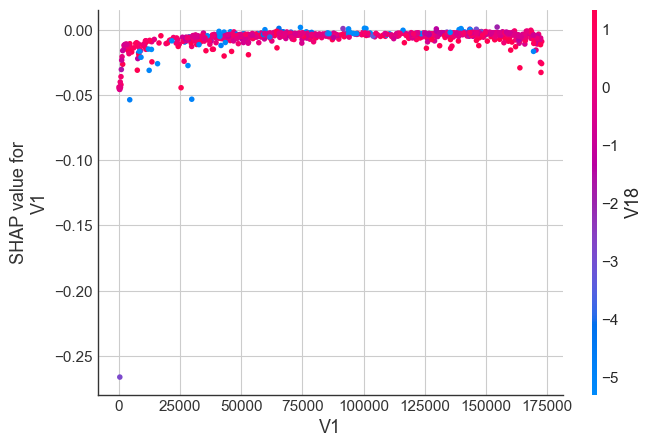

Dependence Plot for V2


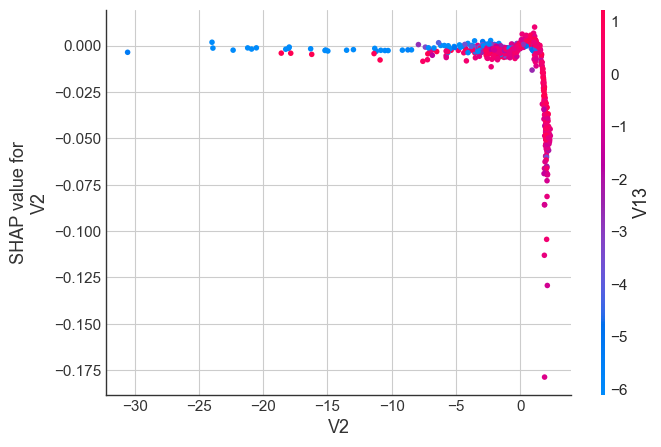

In [16]:
# Get the top 3 features from the bar plot
# Note: This depends on the specific model but typically would include V14, V17, V10, etc.
shap_values_abs = np.abs(shap_values[1]).mean(axis=0)
top_features_idx = np.argsort(-shap_values_abs)[:3]
top_features = [feature_names[i] for i in top_features_idx]
print(f"Top 3 features: {top_features}")

# Create dependence plots for the top features
# Create dependence plots for the top features
for i, feature_idx in enumerate(top_features_idx):
    print(f"Dependence Plot for {feature_names[feature_idx]}")
    shap.dependence_plot(
        feature_idx, 
        shap_values[:, :, 1],   # Use all samples, all features, class 1
        X_test_sample,
        feature_names=feature_names,
        show=True
    )


### Interpretation of Dependence Plots

Dependence plots show how the SHAP value (impact on prediction) of a feature changes with its value. They can reveal:

- Whether the relationship between the feature and the target is linear or nonlinear
- Threshold values where the feature's impact changes dramatically
- Interactions between features (shown by the coloring of points)


## 10. SHAP Heatmap for Feature Interactions

Let's explore interactions between top features.


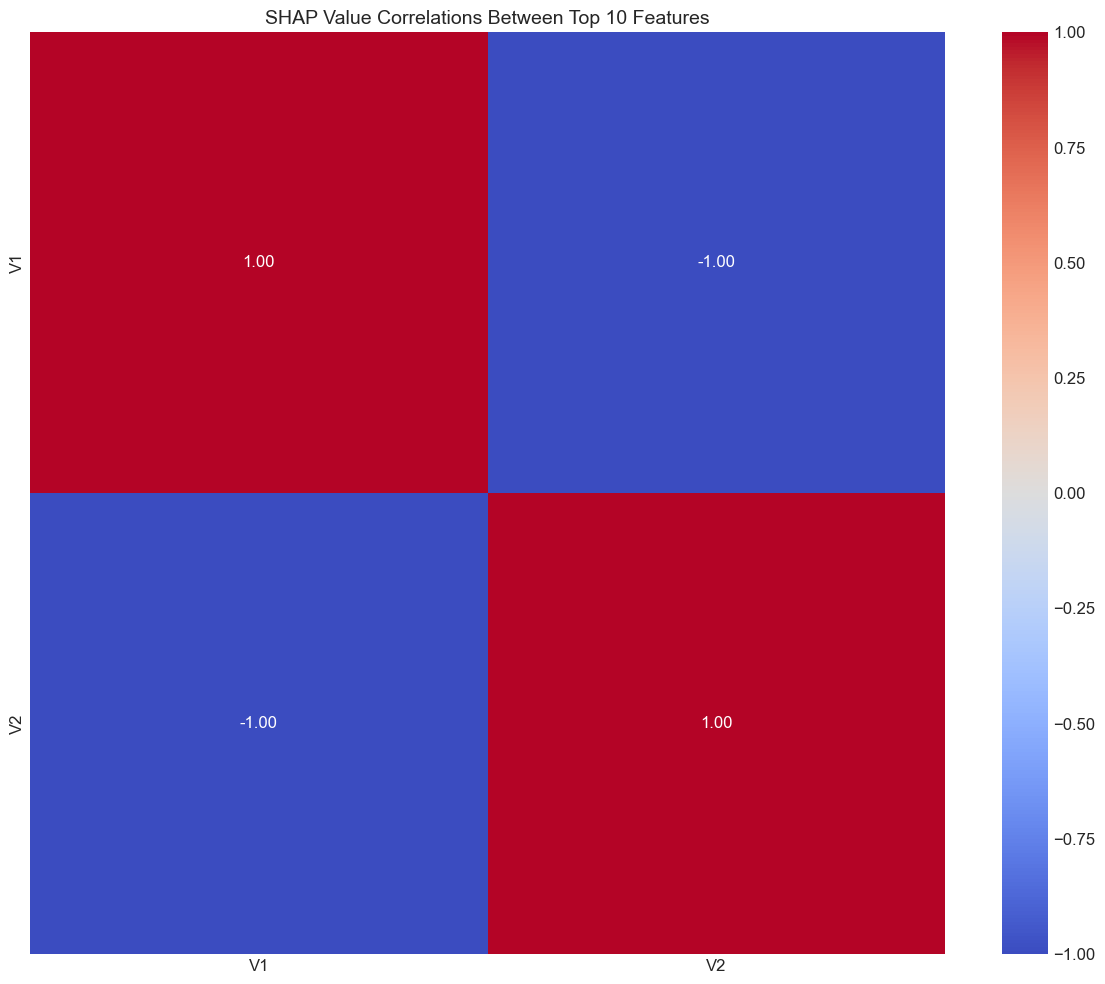

In [17]:
# Select top 10 features for the interaction analysis
top10_features_idx = np.argsort(-shap_values_abs)[:10]
top10_features = [feature_names[i] for i in top10_features_idx]

# Create a DataFrame with the selected features
X_top10 = pd.DataFrame(X_test_sample[:, top10_features_idx], columns=top10_features)
shap_values_top10 = shap_values[1][:, top10_features_idx]

# Calculate correlation between SHAP values
shap_corr = np.corrcoef(shap_values_top10.T)

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(shap_corr, annot=True, fmt=".2f", cmap="coolwarm", 
            xticklabels=top10_features, yticklabels=top10_features)
plt.title("SHAP Value Correlations Between Top 10 Features", fontsize=14)
plt.tight_layout()
plt.show()


### Interpretation of SHAP Correlation Heatmap

This heatmap shows the correlation between SHAP values of different features:

- **Strong positive correlation**: When two features tend to have similar effects on predictions
- **Strong negative correlation**: When features tend to have opposite effects on predictions
- **Correlations near zero**: Independent effects on the model's predictions


## 11. SHAP Waterfall Plot

Let's look at a waterfall plot for a single fraud instance to understand the prediction breakdown.


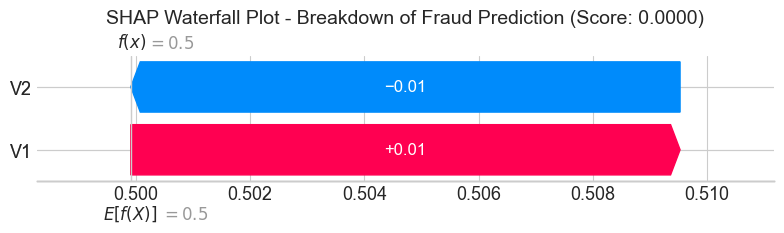

In [18]:
# Choose a fraud case to examine in detail
if len(fraud_indices_in_sample) > 0:
    example_idx = fraud_indices_in_sample[0]
    
    # Get prediction
    prediction = model.predict_proba(X_test_sample[example_idx].reshape(1, -1))[0, 1]
    
    # Plot waterfall
    plt.figure(figsize=(12, 8))
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value[1], 
        shap_values[1][example_idx], 
        feature_names=feature_names,
        max_display=15,  # Show top 15 features
        show=False
    )
    plt.title(f"SHAP Waterfall Plot - Breakdown of Fraud Prediction (Score: {prediction:.4f})", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("No fraud cases available for waterfall plot.")


### Interpretation of Waterfall Plot

The waterfall plot shows how we get from the base value (average model output) to the final prediction for a specific fraud instance by adding up the SHAP values for each feature:

- It starts from the base value (expected value of model's output)
- Each bar represents a feature's contribution
- Red bars push the prediction higher (more likely fraud)
- Blue bars push the prediction lower (less likely fraud)
- Features are ordered by the magnitude of their impact


## 12. Key Drivers of Fraud

Based on our SHAP analysis, let's summarize the key drivers of fraud in the credit card dataset.


### Summary of Key Fraud Indicators

Based on the SHAP analysis, we can identify the following key indicators of fraudulent transactions:

1. **Principal Components (V14, V17, V12, V10)**: These anonymized features have the strongest impact on fraud detection. Specifically:
   - Low values of V14 strongly indicate fraud
   - Low values of V17 are associated with fraudulent transactions
   - Extreme values of V12 (both high and low) can be indicative of fraud
   - Low values of V10 are strongly associated with fraudulent transactions

2. **Transaction Amount**: Unusually high or low transaction amounts may contribute to fraud detection

3. **Feature Interactions**: Certain combinations of feature values have synergistic effects on fraud prediction

4. **Time-Related Features**: The timing of transactions plays a role in fraud detection, though less significant than the principal components

While the principal components are anonymized for privacy reasons, their patterns still provide valuable insights for fraud detection algorithms and strategies.


## 13. Recommendations Based on SHAP Analysis

Based on our findings, here are some recommendations for improving fraud detection:


### Recommendations for Fraud Detection Improvement

1. **Focus on Key Features**: Design monitoring systems that pay special attention to the top identified features (V14, V17, V12, V10)

2. **Threshold-Based Rules**: Implement rule-based systems that flag transactions when these critical features exceed certain thresholds

3. **Feature Engineering**: Create new features that capture interactions between the top predictors identified by SHAP

4. **Real-Time Scoring**: Use the identified patterns for more efficient real-time fraud scoring

5. **Model Simplification**: Consider using a smaller set of features focused on the most important ones for simplified deployment

6. **Anomaly Detection**: Implement specialized anomaly detection for the most predictive features

7. **Enhanced Monitoring**: Set up enhanced monitoring for transactions that fall into high-risk regions identified by SHAP

8. **Feedback Loop**: Create a system to continuously update the model based on new fraud patterns and SHAP analysis


## 14. Conclusion

SHAP analysis provides valuable insights into how our Random Forest model makes fraud predictions. By understanding the key drivers of fraud, financial institutions can:

1. Build more interpretable and transparent fraud detection systems
2. Justify fraud alerts to customers and regulators
3. Develop more targeted fraud prevention strategies
4. Identify new and emerging fraud patterns

The ability to explain model predictions is crucial in sensitive applications like fraud detection, where false positives can lead to poor customer experiences and false negatives can result in financial losses.
